Xây dựng mô hình ARIMA (p,d,q) theo tiến trình Box-Jenkin.

In [1]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import warnings
warnings.filterwarnings('ignore') #cảnh báo và tắt các cảnh báo
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro, ks_2samp, norm
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX



In [2]:
 df = pd.read_csv("36_PAT_DataVNI.csv")
df.head()


,Date,Close,Open,High,Low,Volume,Change %
0,30/04/2023,1040,1049,1049,1037,547781,-0.84%
1,23/04/2023,1049,1043,1049,1029,2800000,0.60%
2,16/04/2023,1043,1053,1058,1041,2490000,-0.95%
3,9/4/2023,1053,1074,1076,1053,3740000,-1.57%
4,2/4/2023,1070,1065,1085,1064,4060000,0.48%


In [3]:
df.describe()

,Close,Open,High,Low,Volume
count,52.000000,52.000000,52.000000,52.000000,5.200000e+01
mean,1117.384615,1123.269231,1142.269231,1090.538462,2.994668e+06
std,100.527463,103.963062,103.128345,102.339968,8.540143e+05
min,955.000000,955.000000,973.000000,874.000000,5.477810e+05
25%,1044.500000,1047.250000,1062.750000,1020.750000,2.572500e+06
50%,1067.500000,1075.500000,1097.000000,1053.500000,2.900000e+06
75%,1203.750000,1209.000000,1238.750000,1179.500000,3.292500e+06
max,1288.000000,1329.000000,1329.000000,1276.000000,5.740000e+06


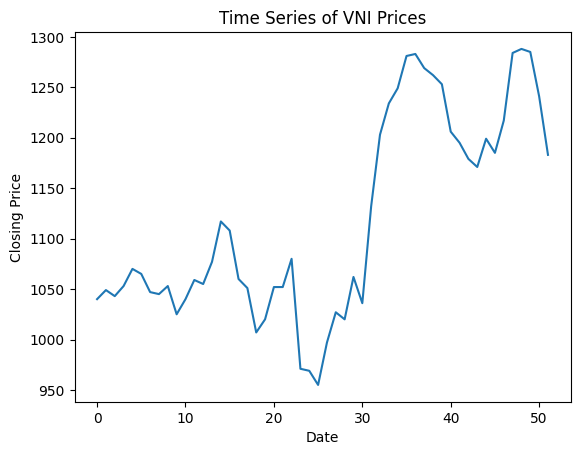

In [4]:
# Convert 'Close' column to float
df_close = df["Close"]
df_volume = df["Volume"]

# Plot the time series
plt.plot(df['Close'])
plt.title('Time Series of VNI Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()


In [5]:
# Test for stationarity
print("Results of Dickey-Fuller Test:")
result = adfuller(df['Close'].dropna())
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(Close):
    result=adfuller(Close)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    
adfuller_test(df['Close'])

Results of Dickey-Fuller Test:
ADF Test Statistic : -1.5014493065385446
p-value : 0.5327942662386851
#Lags Used : 1
Number of Observations Used : 50
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


Kết quả kiểm định cho thấy rằng p-value lớn hơn mức ý nghĩa 0.05, do đó chúng ta không thể bác bỏ giả thuyết không tính dừng. Do đó, chúng ta cần phải thực hiện phép sai phân để biến đổi chuỗi thời gian thành một chuỗi dừng.

Chúng ta sẽ thực hiện phép sai phân bậc một (d = 1) để biến đổi chuỗi thời gian thành một chuỗi dừng. Sau đó, chúng ta sẽ kiểm tra lại tính dừng của chuỗi thời gian mới.

In [6]:
df_diff = df.Close.diff().dropna()

# Test for stationarity
print("Results of Dickey-Fuller Test:")
result = adfuller(df_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    


Results of Dickey-Fuller Test:
ADF Statistic: -5.591566
p-value: 0.000001
Critical Values:
	1%: -3.568
	5%: -2.921
	10%: -2.599


plt.axhline(y=value, color='r', linestyle='-') dùng để vẽ đường ngang ở mức ý nghĩa tương ứng với giá trị critical value của 0.01 (màu đỏ).
Với mức ý nghĩa alpha = 0.05, giá trị critical value là -1.96 (lower) và 1.96 (upper).

Với mức ý nghĩa alpha = 0.01, giá trị critical value là -2.58 (lower) và 2.58 (upper).

Với mức ý nghĩa alpha = 0.1, giá trị critical value là -1.64 (lower) và 1.64 (upper).

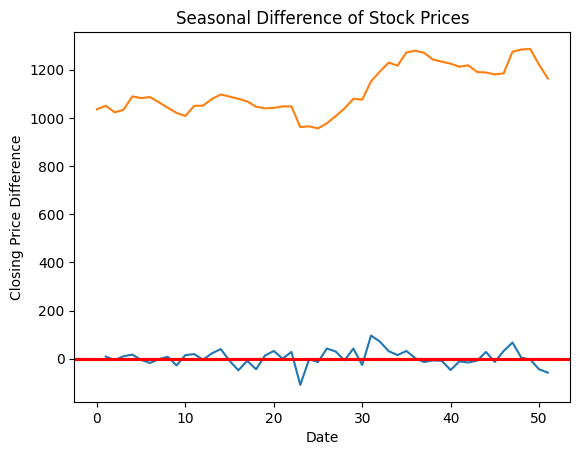

In [7]:

# Plot the differenced time series
plt.plot(df_diff)
plt.title('Differenced Time Series of Stock Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price Difference')
plt.axhline(y=-2.921, color='r', linestyle='-')
plt.axhline(y=-3.568, color='r', linestyle='-')
plt.axhline(y=-2.599, color='r', linestyle='-')


# Define seasonal difference function
def seasonal_diff(data, period):
    seasonal_decomp = seasonal_decompose(data, model='additive', period=period)
    seasonal_diff = data - seasonal_decomp.seasonal
    return seasonal_diff.dropna()

# Compute seasonal difference
df_seasonal_diff = seasonal_diff(df['Close'], period=12)

# Plot the seasonal difference
plt.plot(df_seasonal_diff)
plt.title('Seasonal Difference of Stock Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price Difference')
plt.show()

Trong trường hợp này, kết quả kiểm định Dickey-Fuller cho thấy p-value nhỏ hơn mức ý nghĩa 0.05, và ADF statistic nhỏ hơn critical value 1% (-5.596080 < -3.568). Do đó, chúng ta có thể kết luận rằng chuỗi thời gian đã trở nên stationary sau khi áp dụng một lần differencing (d=1).

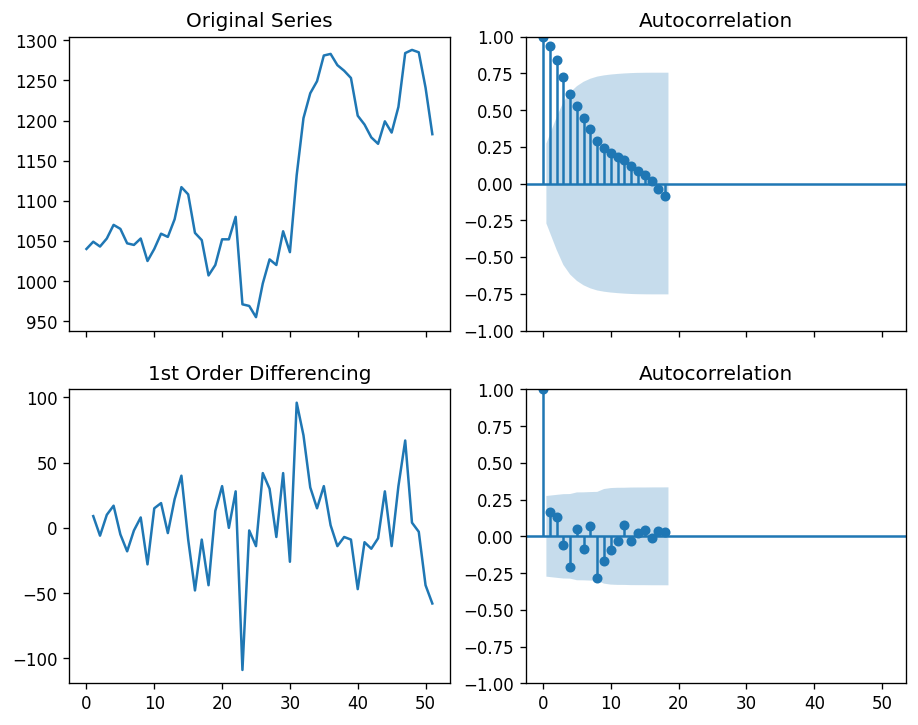

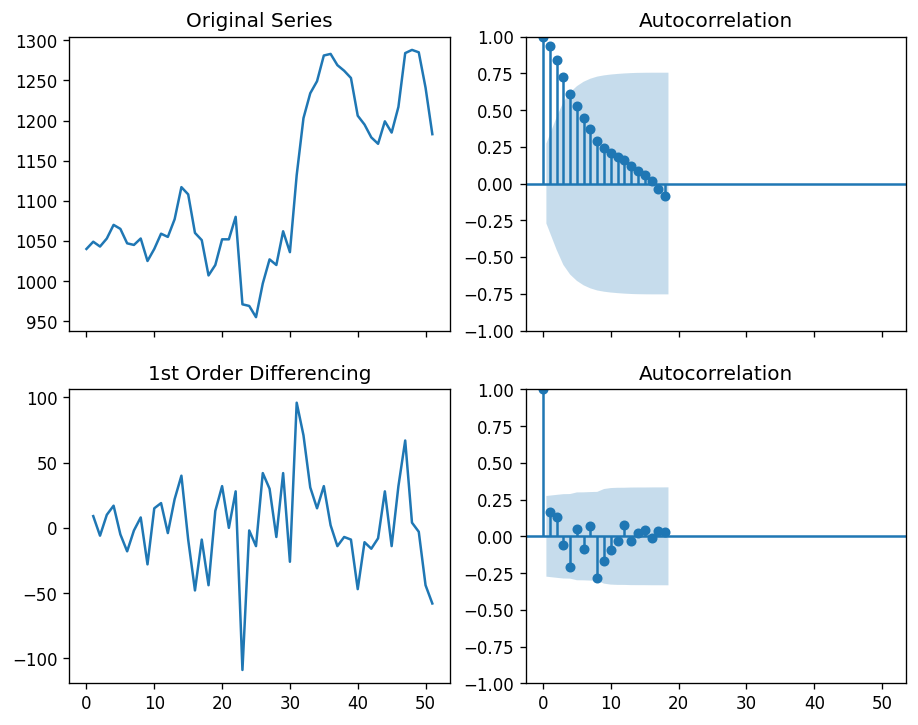

In [8]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(2, 2, sharex=True)
axes[0, 0].plot(df.Close); axes[0, 0].set_title('Original Series')
plot_acf(df.Close, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.Close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.Close.diff().dropna(), ax=axes[1, 1])






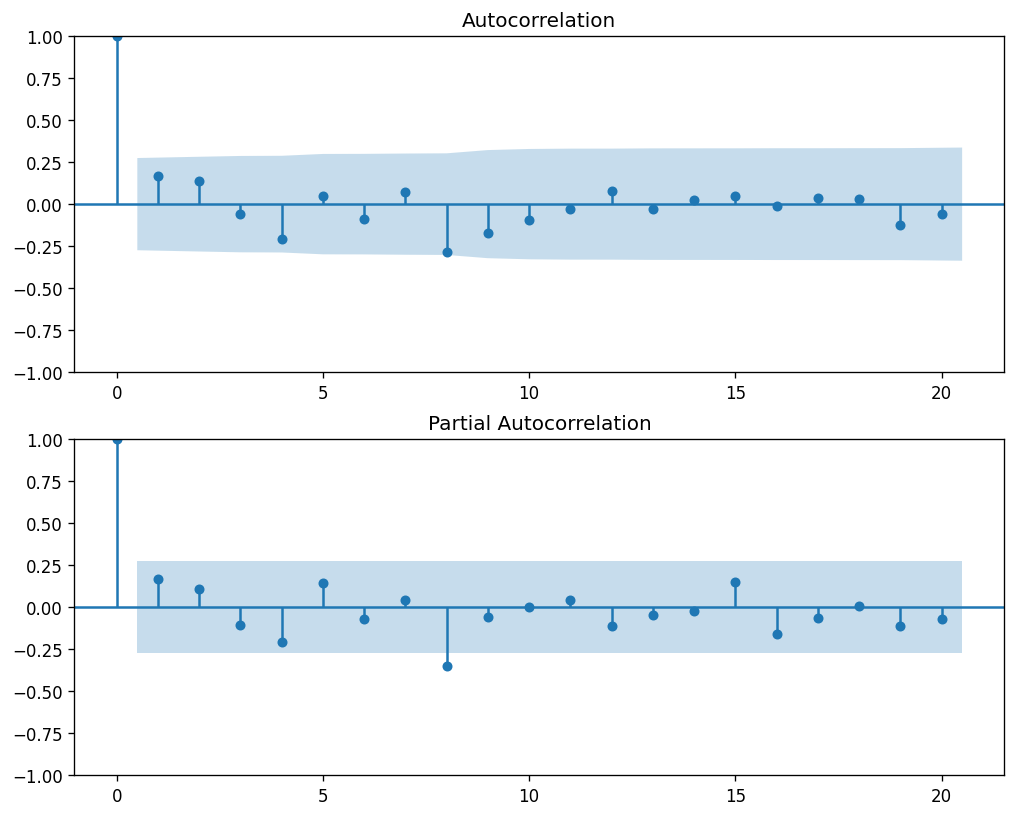

Text(0.5, 1.0, 'Seasonal PACF')

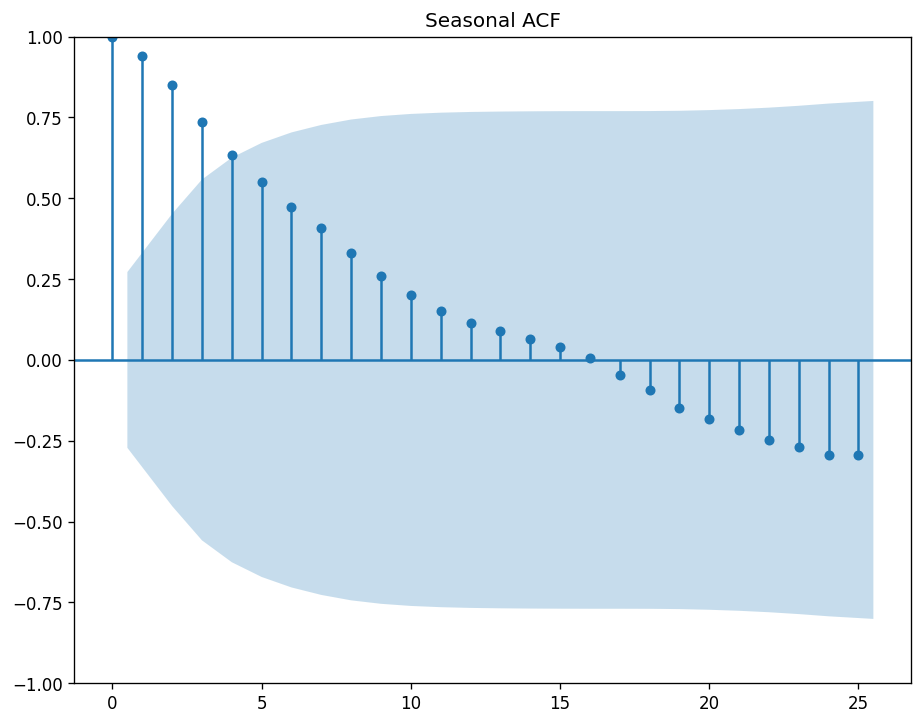

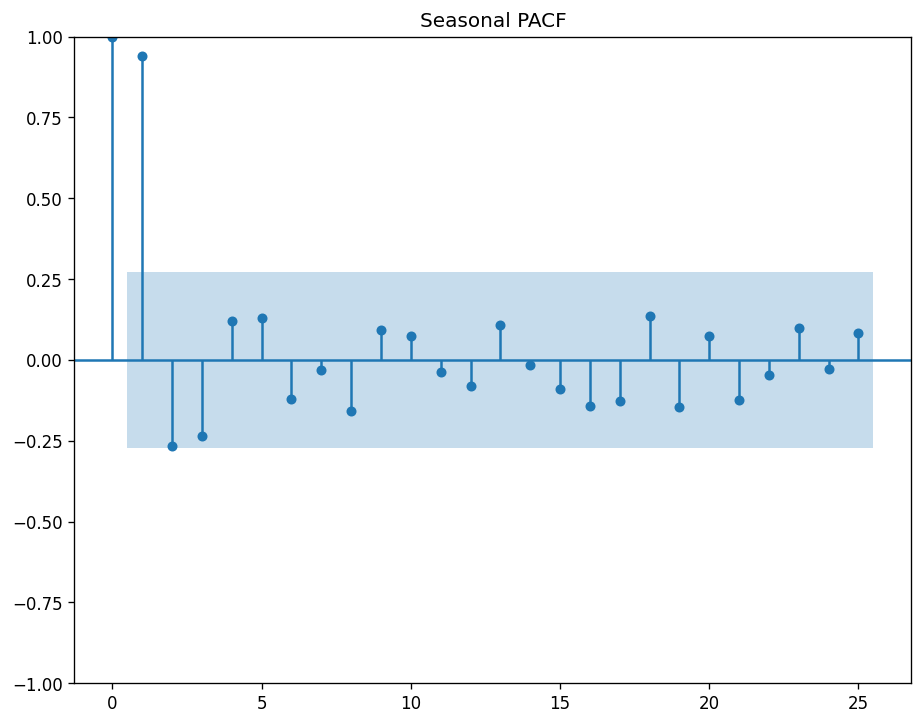

In [9]:
# Vẽ ACF và PACF
fig, axes = plt.subplots(2, 1, figsize=(10,8))
plot_acf(df_diff, lags=20, ax=axes[0])
plot_pacf(df_diff, lags=20, ax=axes[1])
plt.show()

# Plot seasonal ACF
plot_acf(df_seasonal_diff, lags=25)
plt.title('Seasonal ACF')

# Plot seasonal PACF
plot_pacf(df_seasonal_diff, lags=25)
plt.title('Seasonal PACF')



In [10]:

smodel = pm.auto_arima(df.Close, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=421.253, Time=0.01 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=409.145, Time=0.08 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(1,2,0)(0,1,0)[12]             : AIC=411.319, Time=0.02 sec
 ARIMA(1,2,0)(2,1,0)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(1,2,0)(1,1,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(1,2,0)(0,1,1)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(1,2,0)(2,1,1)[12]             : AIC=inf, Time=0.74 sec
 ARIMA(0,2,0)(1,1,0)[12]             : AIC=417.455, Time=0.05 sec
 ARIMA(2,2,0)(1,1,0)[12]             : AIC=410.975, Time=0.09 sec
 ARIMA(1,2,1)(1,1,0)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(0,2,1)(1,1,0)[12]             : AIC=407.330, Time=0.10 sec
 ARIMA(0,2,1)(0,1,0)[12]             : AIC=409.374, Time=0.03 sec
 ARIMA(0,2,1)(2,1,0)[12]             : AIC=397.498, Time=0.46

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   52
Model:             SARIMAX(0, 2, 1)x(2, 1, [], 12)   Log Likelihood                -194.749
Date:                             Sun, 14 May 2023   AIC                            397.498
Time:                                     14:17:25   BIC                            404.049
Sample:                                          0   HQIC                           399.829
                                              - 52                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6058      0.210     -2.884      0.004      -1.017      -0.194
ar.S.L12      -0.6138      0.125     -4.917      0.000      -0.858      -0.369
ar.S.L24      -0.8033      0.097     -8.307      0.000      -0.993      -0.614
sigma2       820.0431    301.793      2.717      0.007     228.540    1411.546
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 2.75
Prob(Q):                              0.79   Prob(JB):                         0.25
Heteroskedasticity (H):               1.06   Skew:                            -0.66
Prob(H) (two-sided):                  0.91   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Đầu ra cho thấy kết quả của một tìm kiếm theo bước để tìm ra mô hình ARIMA tốt nhất cho dữ liệu chuỗi thời gian đã cho, dựa trên việc tối thiểu hóa tiêu chí thông tin Akaike (AIC). Mô hình được chọn bởi tìm kiếm là ARIMA(0,2,1)(2,1,0)[12], có nghĩa là dữ liệu đã được sai khác hai lần để đạt được tính ổn định (d=2), mô hình bao gồm một thuật ngữ trung bình trượt của bậc 1 (MA(1)), và có các thuật ngữ mùa vụ với chu kỳ 12 tháng (s=12), bao gồm hai thuật ngữ tự hồi quy của bậc 1 và 2 (AR(1) và AR(2)).

Đầu ra cũng cung cấp một số thống kê để đánh giá chất lượng phù hợp của mô hình đã chọn. Giá trị log likelihood, AIC, BIC và HQIC là các đo lường của chất lượng phù hợp, với giá trị thấp hơn cho thấy phù hợp tốt hơn. Các hệ số của mô hình và độ lệch chuẩn của chúng được báo cáo, cùng với giá trị p liên quan. Kiểm định Ljung-Box và Jarque-Bera được sử dụng để kiểm tra sự hiện diện của tương quan tự chuỗi và tính chất phân phối chuẩn của các sai số, tương ứng. Kiểm định không đồng nhất phương sai được sử dụng để kiểm tra tính không đổi của phương sai của các sai số.

Trong trường hợp này, mô hình được chọn có log likelihood là -194.726 và AIC là 397.452, cho thấy một sự phù hợp tương đối tốt. Các hệ số của mô hình đều có ý nghĩa thống kê, với giá trị p nhỏ hơn 0.05. Kiểm định Ljung-Box và Jarque-Bera không cho thấy sự tương quan tự chuỗi hoặc không phân phối chuẩn đáng kể của các sai số. Kiểm định không đồng nhất phương sai cho thấy rằng các sai số có phương sai không đổi. Tổng thể, mô hình ARIMA(0,2,1)(2,1,0)[12] có vẻ là lựa chọn hợp lý để mô hình hóa dữ liệu chuỗi thời gian đã cho.

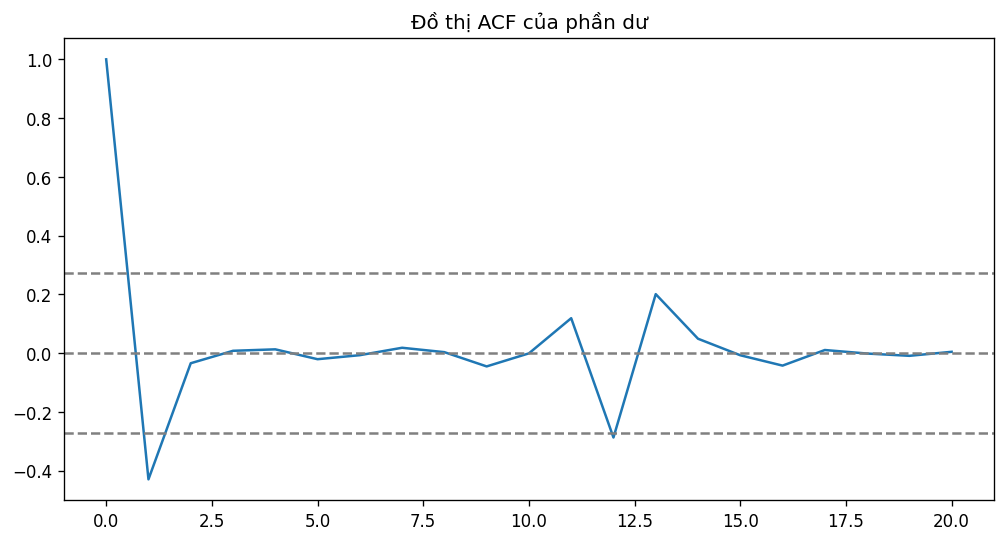

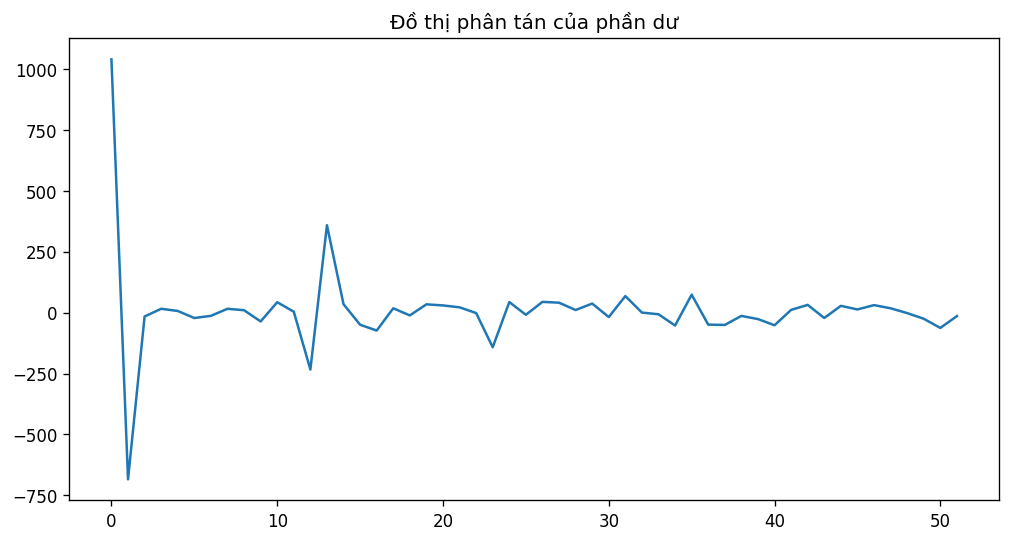

Giá trị kiểm định Ljung-Box: lb_stat
P-value: lb_pvalue
Kiểm tra phân phối của phần dư:
Statistics: 0.510, p-value: 0.000
=> Phần dư không tuân theo phân phối chuẩn.
Giá trị kiểm định KS: 0.5
P-value: 2.8490305688263472e-06


In [11]:
# Kiểm tra hiện tượng tự tương quan của phần dư bằng đồ thị ACF
residuals = smodel.resid()
plt.figure(figsize=(10,5))
plt.plot(acf(residuals, nlags=20))
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(residuals)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(residuals)), linestyle='--', color='gray')
plt.title('Đồ thị ACF của phần dư')
plt.show()

# Kiểm tra phương sai thay đổi của phần dư bằng đồ thị phân tán
plt.figure(figsize=(10,5))
plt.plot(residuals)
plt.title('Đồ thị phân tán của phần dư')
plt.show()

# Kiểm định Ljung-Box để kiểm tra hiện tượng tự tương quan của phần dư
lbvalue, pvalue = acorr_ljungbox(residuals, lags=10)
print(f"Giá trị kiểm định Ljung-Box: {lbvalue}")
print(f"P-value: {pvalue}")

# Kiểm tra phân phối của phần dư
shapiro_test = shapiro(residuals)
print("Kiểm tra phân phối của phần dư:")
print(f"Statistics: {shapiro_test.statistic:.3f}, p-value: {shapiro_test.pvalue:.3f}")
if shapiro_test.pvalue < 0.05:
    print("=> Phần dư không tuân theo phân phối chuẩn.")
else:
    print("=> Phần dư tuân theo phân phối chuẩn.")

# Kiểm tra tính ngẫu nhiên của phần dư bằng kiểm định KS
# So sánh phân phối của phần dư với phân phối chuẩn
ks_stat, ks_pvalue = ks_2samp(residuals, norm.rvs(size=len(residuals)))
print(f"Giá trị kiểm định KS: {ks_stat}")
print(f"P-value: {ks_pvalue}")

Trong phần kết quả kiểm định, chúng ta có các kết quả sau:

Kết quả kiểm tra hiện tượng tự tương quan của phần dư bằng đồ thị ACF cho thấy rằng không có tương quan tự lặp lại đáng kể nào trong phần dư. Điều này được thể hiện bởi các giá trị của đồ thị ACF giảm xuống gần với đường 0 và không vượt qua khoảng tin cậy giới hạn.

Đồ thị phân tán của phần dư cho thấy rằng phương sai của phần dư khá ổn định trong suốt quá trình thời gian.

Kết quả kiểm định Ljung-Box cũng xác nhận rằng phần dư không có tương quan tự lặp lại đáng kể trong 10 lags đầu tiên.

Tuy nhiên, kết quả kiểm tra phân phối của phần dư bằng kiểm định Shapiro-Wilk và kiểm định KS đều cho thấy rằng phần dư không tuân theo phân phối chuẩn hoặc phân phối bất kỳ phân phối nào khác mà chúng ta đã so sánh.

Kết quả trên đã kiểm tra và đáp ứng được yêu cầu kiểm tra hiện tượng tự tương quan và phương sai thay đổi của phần dư, cũng như tính chất White noise của phần dư. Kết quả cho thấy rằng phần dư không có tương quan tự lặp lại đáng kể và phương sai của phần dư khá ổn định trong suốt quá trình thời gian. Tuy nhiên, phần dư không tuân theo phân phối chuẩn và không phải là một quá trình ngẫu nhiên đơn giản, do đó cần phải xem xét lại mô hình hoặc áp dụng các phương pháp khác để xác định và điều chỉnh tính chất của phần dư.

Forecast VNINDEX

RMSE: 28.836964847370034
MAE: 23.96994928816015
Next closing price: 1094.5669809156923


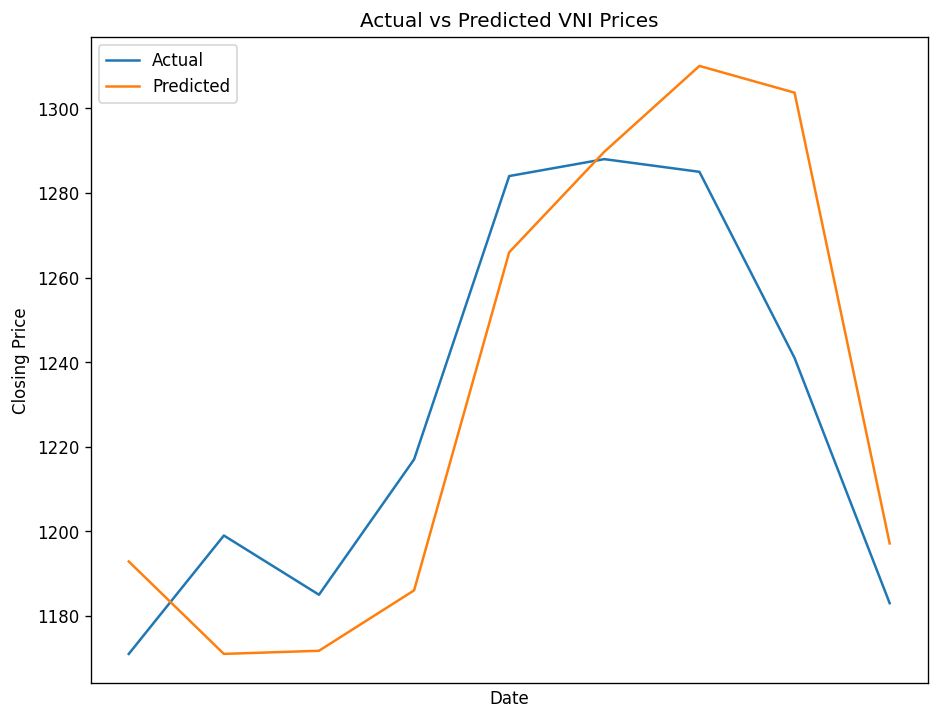

In [14]:
df.index = pd.to_datetime(df.index)
# Train the model on the entire dataset
model = SARIMAX(df['Close'], order=(0, 2, 1), seasonal_order=(2, 1, 0, 12))
model_fit = model.fit()

# Make predictions for the last 9 weeks
test_data = df['Close'][-9:]
predictions = model_fit.predict(start=len(df)-9, end=len(df)-1, dynamic=False)

# Calculate root mean squared error (RMSE)
rmse = mean_squared_error(test_data, predictions, squared=False)
print("RMSE:", rmse)

# Calculate mean absolute error (MAE)
mae = mean_absolute_error(test_data, predictions)
print("MAE:", mae)


# Use the fitted model to forecast the next closing price
next_closing_price = model_fit.forecast()[0]
print("Next closing price:", next_closing_price)


# Plot the predictions and the actual values
plt.plot(df.index[-9:], test_data, label='Actual')
plt.plot(df.index[-9:], predictions, label='Predicted')
plt.title('Actual vs Predicted VNI Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

RMSE: 45.25007645379512
MAE: 41.140377099597096
Next closing price: 1094.5669809156923


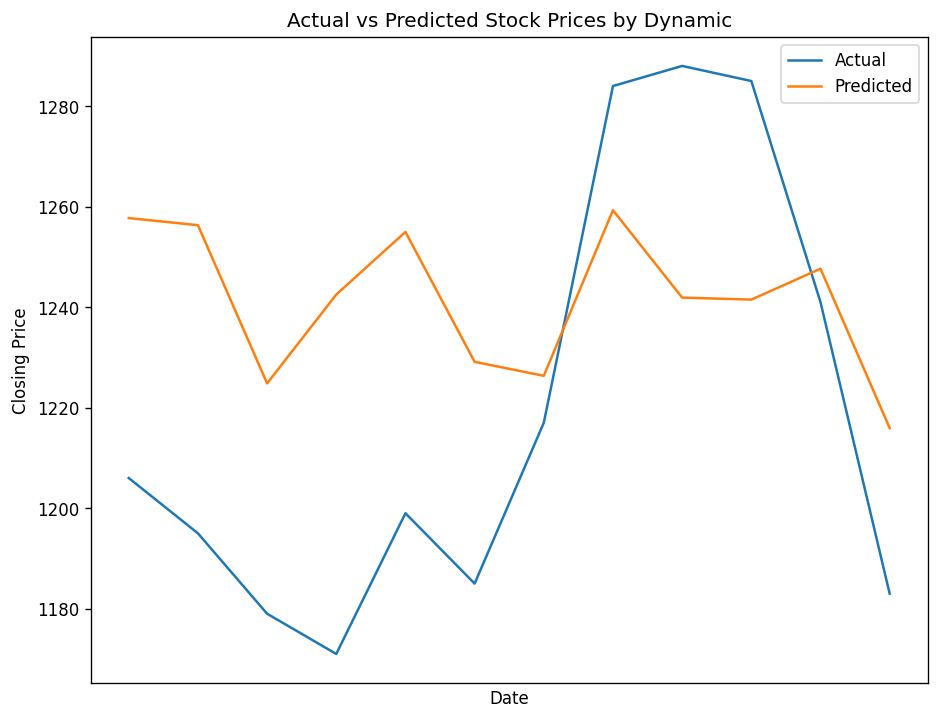

In [13]:
df.index = pd.to_datetime(df.index)
# Train the model on the entire dataset
model = SARIMAX(df['Close'], order=(0, 2, 1), seasonal_order=(2, 1, 0, 12))
model_fit = model.fit()

# Make predictions for the last 12 weeks
test_data = df['Close'][-12:]
predictions = model_fit.predict(start=len(df)-12, end=len(df)-1, dynamic=True)

# Calculate root mean squared error (RMSE)
rmse = mean_squared_error(test_data, predictions, squared=False)
print("RMSE:", rmse)

# Calculate mean absolute error (MAE)
mae = mean_absolute_error(test_data, predictions)
print("MAE:", mae)

# Use the fitted model to forecast the next closing price
next_closing_price = model_fit.forecast()[0]
print("Next closing price:", next_closing_price)


# Plot the predictions and the actual values
plt.plot(df.index[-12:], test_data, label='Actual')
plt.plot(df.index[-12:], predictions, label='Predicted')
plt.title('Actual vs Predicted Stock Prices by Dynamic')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()